# Ground Truth Preparation & Annotation Strategy

In [12]:
import os
import json
import random
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
# Define path
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path("..")
DATA_ROOT = BASE_DIR / "data"

RAW_EARLY = DATA_ROOT / "raw" / "Tomato___Early_blight"
RAW_HEALTHY = DATA_ROOT / "raw" / "Tomato___healthy"

assert RAW_EARLY.exists()
assert RAW_HEALTHY.exists()

In [3]:
# Load image file path
early_files = sorted([p.name for p in RAW_EARLY.glob("*.jpg")])
healthy_files = sorted([p.name for p in RAW_HEALTHY.glob("*.jpg")])

print(f"Early Blight images : {len(early_files)}")
print(f"Healthy images     : {len(healthy_files)}")

Early Blight images : 1000
Healthy images     : 1591


In [4]:
# Sample annotation
random.seed(42)

N_EARLY_ANNOTATE = 120
N_HEALTHY_ANNOTATE = 80

early_selected = random.sample(early_files, N_EARLY_ANNOTATE)
healthy_selected = random.sample(healthy_files, N_HEALTHY_ANNOTATE)

print("Sample annotation set created")

Sample annotation set created


In [5]:
# Save sample annotation to JSON
annotation_list = {
    "early_blight": early_selected,
    "healthy": healthy_selected
}

with open(DATA_ROOT / "annotation_list.json", "w") as f:
    json.dump(annotation_list, f, indent=2)

print("annotation_list.json saved")

annotation_list.json saved


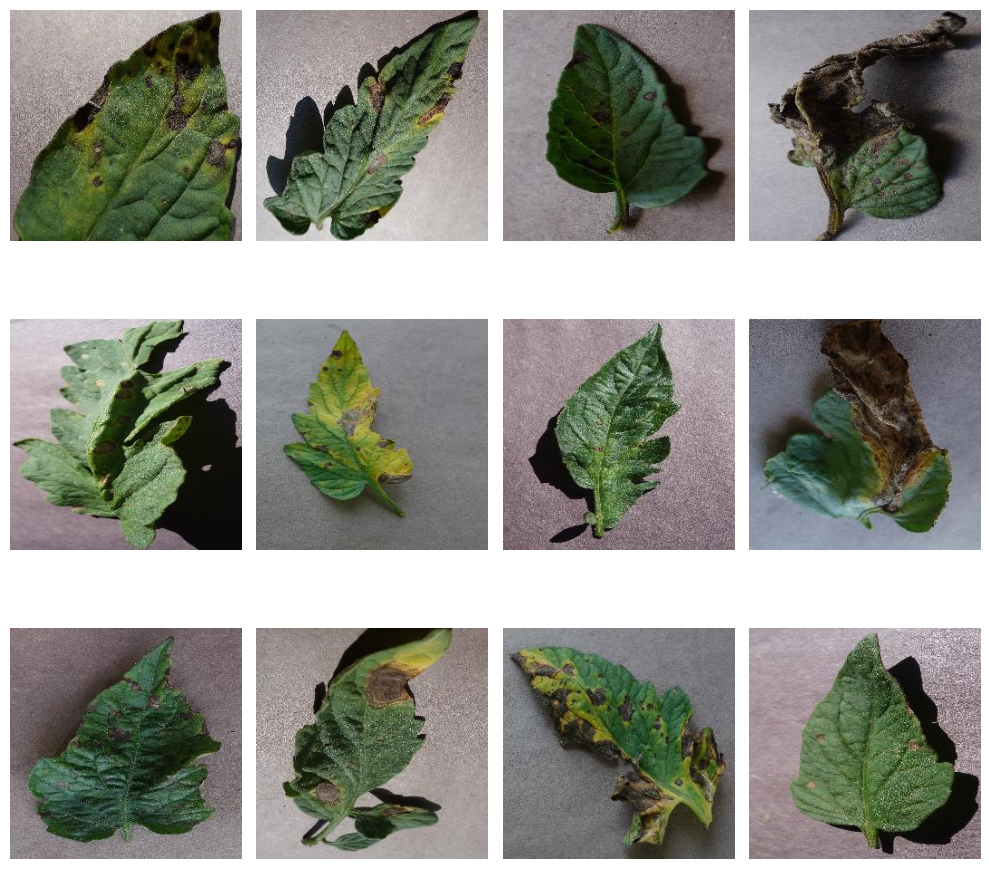

In [6]:
def show_samples(file_list, folder, n=12):
    sample = random.sample(file_list, n)
    plt.figure(figsize=(10, 10))
    
    for i, fname in enumerate(sample):
        img = cv2.imread(str(folder / fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_samples(early_selected, RAW_EARLY)

## Mask validation

In [9]:
# Path file
LEAF_EARLY_OUT = DATA_ROOT / "masks" / "early_blight" / "leaf"
DISEASE_EARLY_OUT = DATA_ROOT / "masks" / "early_blight" / "disease"
LEAF_HEALTHY_OUT = DATA_ROOT / "masks" / "healthy" / "leaf"

RAW_EARLY = DATA_ROOT / "raw" / "Tomato___Early_blight"
RAW_HEALTHY = DATA_ROOT / "raw" / "Tomato___healthy"

with open(DATA_ROOT / "annotation_list.json") as f:
    annotation_list = json.load(f)

early_files = annotation_list["early_blight"]
healthy_files = annotation_list["healthy"]

In [10]:
errors = []

def mask_name(fname):
    return Path(fname).stem + ".png"
for fname in early_files:
    leaf = LEAF_EARLY_OUT / mask_name(fname)
    disease = DISEASE_EARLY_OUT / mask_name(fname)

    if not leaf.exists():
        errors.append(f"Leaf mask missing (early): {fname}")
    if not disease.exists():
        errors.append(f"Disease mask missing (early): {fname}")

for fname in healthy_files:
    leaf = LEAF_HEALTHY_OUT / mask_name(fname)

    if not leaf.exists():
        errors.append(f"Leaf mask missing (healthy): {fname}")

print(f"Total issues found: {len(errors)}")
for e in errors[:60]:
    print(e)

Total issues found: 0


## Split Data

In [18]:
import json
import random
from pathlib import Path

DATA_ROOT = Path("../data")

with open(DATA_ROOT / "annotation_list.json") as f:
    annotation_list = json.load(f)

early_files = annotation_list["early_blight"]
healthy_files = annotation_list["healthy"]

In [19]:
def split_files(files, train_ratio=0.7, val_ratio=0.15, seed=42):
    files = files.copy()
    random.Random(seed).shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    return {
        "train": files[:n_train],
        "val": files[n_train:n_train + n_val],
        "test": files[n_train + n_val:]
    }

In [20]:
# Split classes
early_split = split_files(early_files)
healthy_split = split_files(healthy_files)

print("Early blight split:", {k: len(v) for k, v in early_split.items()})
print("Healthy split    :", {k: len(v) for k, v in healthy_split.items()})

Early blight split: {'train': 84, 'val': 18, 'test': 18}
Healthy split    : {'train': 56, 'val': 12, 'test': 12}


In [21]:
# Save split to JSON
splits = {
    "early_blight": early_split,
    "healthy": healthy_split
}

with open(DATA_ROOT / "splits.json", "w") as f:
    json.dump(splits, f, indent=2)

print("splits.json saved")

splits.json saved


In [ ]:
# Overlap check
def check_overlap(split):
    return (
        set(split["train"]) & set(split["val"]) |
        set(split["train"]) & set(split["test"]) |
        set(split["val"]) & set(split["test"])
    )

print("Early overlap :", check_overlap(early_split))
print("Healthy overlap:", check_overlap(healthy_split))

Early overlap : set()
Healthy overlap: set()
